In [1]:
cd MF

/home/shse/Documents/sim_mf_bonne/MF


In [2]:
import numpy as np
import sys
#sys.path.append('mean_field_adapt')
#from transfer_functions.tf_simulation import single_experiment_2,single_experiment
from transfer_functions.load_config import load_transfer_functions,load_transfer_functions_with_ALL_params,load_transfer_functions_with_ALL_params_ij
from scipy.integrate import odeint
from single_cell_models.cell_library import get_neuron_params
from synapses_and_connectivity.syn_and_connec_library import get_connectivity_and_synapses_matrix
from transfer_functions.tf_simulation import reformat_syn_parameters
import matplotlib.pylab as plt
from transfer_functions.data import *
from graphs import *


from scipy.optimize import fsolve
from scipy.optimize import minimize
import math

In [6]:
%load_ext autoreload
%autoreload 2

In [3]:
from MF_functions_clean import *

## First, build the MF architecture and set the right parameters


In [14]:
h=0.0001
T=0.005
Ntot=10000

number_of_populations=4 # variate this paramater, first are excitators and second inihibitors 
number_of_adaptive=2

p_con=np.ones((4,4))*(0.05)#np.ones((4,4))*(0.05) ou number_of_pop*0.05
delays=np.zeros((4,4))*(0.05)
#p_con[2][2]=0.6 #inh tres connecté p_con[0][3]=p_con[1][2]=p_con[2][3]=p_con[3][2]=0
p_con[3][0]=p_con[2][1]=p_con[2][3]=p_con[3][2]=0 ## the two FS populations are not connected !
p_pois=np.ones(4)*0.05

''' Now params becomes a dictionary'''

#numb_par=28
params={}

params['diff']=[0,0,0,0] # by default nothing changes from neuron model
params['tstep']=5e-4 
params['numb_var']=number_of_populations**2+number_of_populations+number_of_adaptive#14 # total numb of var
# remove number_of_populations**2 for first order 
params['tauw']=[1,1,1e-3,1e-3] # tau_w
params['a']=[0,0,0,0] # a 0,0
params['b']=[60e-12,60e-12,0,0] # b 
#params['w']=[10e-12,10e-12,0,0]
params['El']=[-70e-3,-70e-3,-65e-3,-65e-3] # El -70e-3,-65e-3
params['total_size']=10000
params['size_subpop']=[8000,8000,2000,2000] 
params['numb_pop']=number_of_populations
params['numb_adapt']=number_of_adaptive
params['tau_e']=5e-3 # Tau_e
params['tau_i']=5e-3 # Tau_i
params['qe']=2e-9 # Qe à 2e-9 par vers 200Hz
params['qi']=5e-9 # Qi
params['Ee']=0 # Ee
params['Ei']=-80e-3 # Ei
params['Gl']=[10e-9,10e-9,10e-9,10e-9]
params['Vthre']=[-50e-3,-50e-3,-50e-3,-50e-3]
params['Cm']=[200e-12,200e-12,200e-12,200e-12]


params['delays']=delays

params['h']=h
params['T']=T
params['mu']=mu_V_dN_dp #_FO (for firdt order)

params['ext_inp']=[0.8,0.8,0.8,0.8] #external input : Poisson law, change params 2.5 HZ
params['inp_funct']=0 # input function
params['inp_par']=0 # input parameters
params['numb_sub_exc']=2# numb_sub_exc
params['numb_sub_inh']=2# numb_sub_inh
params['p_conn']=p_con # not anymore dp, here it is plain p 
params['p_pois']=p_pois



print(params)

{'diff': [0, 0, 0, 0], 'tstep': 0.0005, 'numb_var': 22, 'tauw': [1, 1, 0.001, 0.001], 'a': [0, 0, 0, 0], 'b': [6e-11, 6e-11, 0, 0], 'El': [-0.07, -0.07, -0.065, -0.065], 'total_size': 10000, 'size_subpop': [8000, 8000, 2000, 2000], 'numb_pop': 4, 'numb_adapt': 2, 'tau_e': 0.005, 'tau_i': 0.005, 'qe': 2e-09, 'qi': 5e-09, 'Ee': 0, 'Ei': -0.08, 'Gl': [1e-08, 1e-08, 1e-08, 1e-08], 'Vthre': [-0.05, -0.05, -0.05, -0.05], 'Cm': [2e-10, 2e-10, 2e-10, 2e-10], 'delays': array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), 'h': 0.0001, 'T': 0.005, 'mu': <function mu_V_dN_dp at 0x7f38b6e8e430>, 'ext_inp': [0.8, 0.8, 0.8, 0.8], 'inp_funct': 0, 'inp_par': 0, 'numb_sub_exc': 2, 'numb_sub_inh': 2, 'p_conn': array([[0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05],
       [0.05, 0.  , 0.05, 0.  ],
       [0.  , 0.05, 0.  , 0.05]]), 'p_pois': array([0.05, 0.05, 0.05, 0.05])}


In [15]:

NTWK='CONFIG1'


NRN1='RS-cell'
NRN2='FS-cell'
#NRN3='RS-cell'
#NRN4='FS-cell'


TF_temp = load_transfer_functions_with_ALL_params(NRN1, NRN2, NTWK,params)
#TF_temp_2 = load_transfer_functions_with_ALL_params_ij(NRN1, NRN2, NTWK,par,1,3)
 # lazy to rewrite a load_TF function

TF=(TF_temp[0],TF_temp[0],TF_temp[1],TF_temp[1]) # TF defined as a tuple

params['TF']=TF



### Integration of the MF equations with delays

##### Straight to second order !

In [10]:
#np.random.seed(10)
#x0=np.random.rand(7)*1e-5

x0=np.ones(params['numb_var'])*1e-2 
x0[0]=0.6 #ve1 exp 
x0[1]=0.72 #ve2 exp ajout 20%
x0[2]=7.0 #vi1 exp 
x0[3]=8.4 #vi2 exp  ajout 20%
x0[20]=x0[0]*60e-12 #x0[0]*60e-12 ici point fixe pour la stabilité
x0[21]=x0[1]*60e-12 #w exp

print(x0)
time=0
t_trace=[]
x_trace_RS=[]
TF_trace_RS=[]


x_trace_RS.append(x0.copy())
#x_trace_RS.append(x0.copy())

##################### INITIATE THE PAST COORDINANTES ##########################

delay_matrix=np.matrix(delays)
max_delay=delay_matrix.max()

#### Associated number of time steps ####

steps=int(max_delay/params['tstep'])

for i in range(steps):x_trace_RS.append(x0.copy())
    
##################################################################################

print(x0)
time=0 #ou 0 à voir 
    
for i in np.arange(0,2,par['tstep']):
    params['x_hist']=np.transpose(x_trace_RS)
    TF_inst=rk4_dN_dp_General(x0,params,time,MeanField_dN_dp)
    if (i%0.5==0):print('i = ', i, '\n')
    time+=params['tstep']
    t_trace.append(time)
    x_trace_RS.append(x0.copy())
    TF_trace_RS.append(TF_inst.copy())
    

[6.00e-01 7.20e-01 7.00e+00 8.40e+00 1.00e-02 1.00e-02 1.00e-02 1.00e-02
 1.00e-02 1.00e-02 1.00e-02 1.00e-02 1.00e-02 1.00e-02 1.00e-02 1.00e-02
 1.00e-02 1.00e-02 1.00e-02 1.00e-02 3.60e-11 4.32e-11]
[6.00e-01 7.20e-01 7.00e+00 8.40e+00 1.00e-02 1.00e-02 1.00e-02 1.00e-02
 1.00e-02 1.00e-02 1.00e-02 1.00e-02 1.00e-02 1.00e-02 1.00e-02 1.00e-02
 1.00e-02 1.00e-02 1.00e-02 1.00e-02 3.60e-11 4.32e-11]
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 



In [5]:
np.save('x_trace_60_new.npy',x_trace_RS)

NameError: name 'x_trace_RS' is not defined

In [13]:
x=np.load('x_trace_60_new.npy') # save

In [11]:
final_state=x_trace_RS[-1]
print(final_state)
#intégrer la dérivé , ici valeurs de nu_out 
#trouver pts fixes des, donné les freq vers les quelles elles 

[ 3.37756235e-03  3.31594118e-03  5.21178907e+00  5.21157900e+00
  3.97191432e-05  8.55720154e-07  7.26662115e-05 -3.49797420e-05
  8.55720154e-07  3.89785287e-05 -3.43130822e-05  7.12700366e-05
  7.26662115e-05 -3.43130822e-05  5.66933688e-02  2.22976688e-04
 -3.49797420e-05  7.12700366e-05  2.22976688e-04  5.66869475e-02
  5.05310745e-12  6.02639164e-12]


In [ ]:
final_state=[ 3.37756235e-03, 3.31594118e-03, 5.21178907e+00, 5.21157900e+00,
             3.97191432e-05, 8.55720154e-07, 7.26662115e-05, -3.49797420e-05,
             8.55720154e-07, 3.89785287e-05, -3.43130822e-05, 7.12700366e-05,
             7.26662115e-05, -3.43130822e-05, 5.66933688e-02, 2.22976688e-04,
             -3.49797420e-05, 7.12700366e-05, 2.22976688e-04, 5.66869475e-02,
             5.05310745e-12, 6.02639164e-12]

In [29]:
x_transp=np.transpose(x_trace_RS)
TF_transp=np.transpose(TF_trace_RS)
ve1=x_transp[0]#[1000:] # remove first 10000 elements
ve2=x_transp[1]#[1000:]
vi1=x_transp[2]#[1000:]
vi2=x_transp[3]#[1000:]
#ce1i1=np.sqrt(x_transp[5])#[1000:]
#cii=np.sqrt(x_transp[5])#[1000:]
w1=x_transp[20]
w2=x_transp[21]
#cv_i=cee/ve
#cv_e=cii/vi
#print(cee[:1000],cii[:1000])

In [9]:
ve1[1:].shape

(4000,)

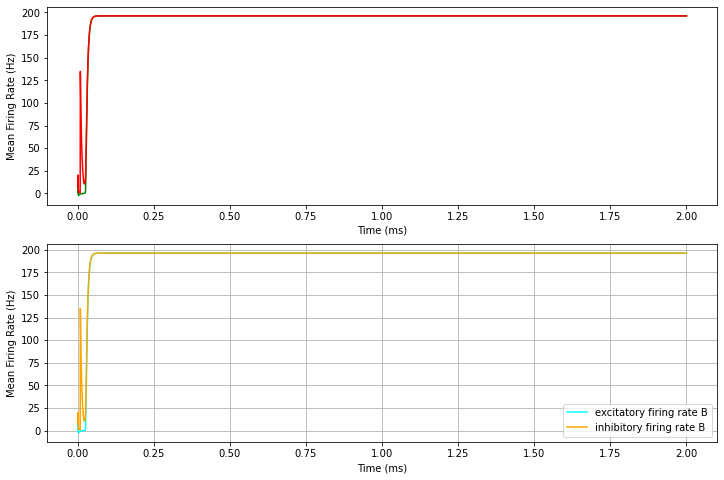

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(t_trace, ve1[1:], color="green", label="excitatory firing rate A")
axs[0].plot(t_trace, vi1[1:], color="red", label="inhibitory firing rate A")
axs[1].plot(t_trace, ve1[1:], color="cyan", label="excitatory firing rate B")
axs[1].plot(t_trace, vi2[1:], color="orange", label="inhibitory firing rate B")
#axs[0].plot(TimBinned/1000,  popRateG2, color="green",ls="--", label="excitatory firing rate")
#plt.plot(TimBinned/1000, popRateG1, color="red",ls="--", label="inhibitory firing rate")

#plt.grid(True)
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("Mean Firing Rate (Hz)")
axs[1].set_xlabel("Time (ms)")
axs[1].set_ylabel("Mean Firing Rate (Hz)")

plt.legend()
plt.grid(True)
#plt.title("Mean-Field Dynamics")
#plt.ylim(-20,20)
#plt.xlim(0,0.1)
plt.show()

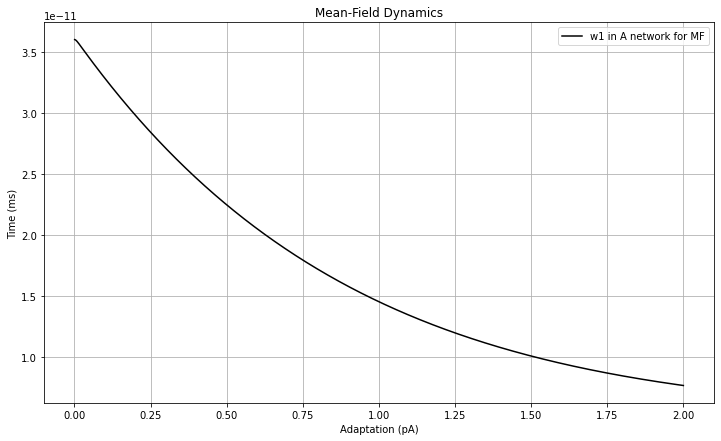

In [11]:
plt.figure(figsize=(12, 7))
plt.plot(t_trace,w1[1:],color="black",label="w1 in A network for MF")
#plt.plot(t_trace,w2,color="black",label="w2 in A network for MF")
#for a in range(len(LVG1)):
    #plt.plot(Lt2G2/400,LwG2[a],color="blue",ls='--',label="w1 in A for Adex")
#for a in range(len(LVG3)):
    #plt.plot(Lt2G4/400,LwG4[a],color="black",ls='--',label="w2 in A for Adex")

plt.xlabel("Adaptation (pA)")
plt.grid(True)
plt.ylabel("Time (ms)")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(-20,20)
#plt.xlim(0,0.1)
plt.show()

In [38]:
delays=np.zeros((4,4))
#delays[0][3]=delays[1][2]=0.001 #proche  #delays[0][1]=delays[1][0]
delays[0][1]=delays[0][3]=delays[1][0]=delays[1][2]=0.005 #delai colonne distantes entre exc-inh et exc-exc colonnes diff
#print(delays)

In [39]:
np.random.seed(10)
x0=final_state.copy()
#x0[0]+=0.5
#x0[1]+=0.5
print(x0)
#time=0
t_trace=[]
x_trace_RS=[]
TF_trace_RS=[]

x_trace_RS.append(x0.copy())
#x_trace_RS.append(x0.copy())

##################### INITIATE THE PAST COORDINANTES ##########################

delay_matrix=np.matrix(delays)
max_delay=delay_matrix.max()
print('Max delay = ', max_delay)
#### Associated number of time steps ####

steps=int(max_delay/params['tstep'])

for i in range(steps):x_trace_RS.append(x0.copy())
    
##################################################################################

print(x0)
time=max_delay
    
for i in np.arange(0,2,params['tstep']):
    params['x_hist']=np.transpose(x_trace_RS)
    TF_inst=Euler_method_General(x0,params,time,MeanField_dN_dp_delay)
    if (i%0.5==0):print('i = ', i, '\n')
    time+=params['tstep']
    t_trace.append(time)
    x_trace_RS.append(x0.copy())
    TF_trace_RS.append(TF_inst.copy())

[1.96720558e+02 1.96720558e+02 1.96220558e+02 1.96220558e+02
 4.66887182e-02 3.36622310e-04 5.87614123e-04 1.71032462e-04
 3.36622310e-04 4.66887182e-02 1.71032462e-04 5.87614115e-04
 5.87614123e-04 1.71032462e-04 1.86237692e-01 5.44261421e-06
 1.71032462e-04 5.87614115e-04 5.44261421e-06 1.86237692e-01
 1.01331891e-08 1.01331921e-08]
Max delay =  0.005
[1.96720558e+02 1.96720558e+02 1.96220558e+02 1.96220558e+02
 4.66887182e-02 3.36622310e-04 5.87614123e-04 1.71032462e-04
 3.36622310e-04 4.66887182e-02 1.71032462e-04 5.87614115e-04
 5.87614123e-04 1.71032462e-04 1.86237692e-01 5.44261421e-06
 1.71032462e-04 5.87614115e-04 5.44261421e-06 1.86237692e-01
 1.01331891e-08 1.01331921e-08]
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 



In [40]:
final_state1=x_trace_RS[-1]
print(final_state1)

[1.96220558e+02 1.96220558e+02 1.96220558e+02 1.96220558e+02
 4.66887181e-02 3.36622310e-04 5.87614108e-04 1.71032461e-04
 3.36622310e-04 4.66887181e-02 1.71032458e-04 5.87614114e-04
 5.87614108e-04 1.71032458e-04 1.86237691e-01 5.44261371e-06
 1.71032461e-04 5.87614114e-04 5.44261371e-06 1.86237691e-01
 1.15514093e-08 1.15514097e-08]


In [41]:
x_transp=np.transpose(x_trace_RS)
TF_transp=np.transpose(TF_trace_RS)
ve1=x_transp[0]#[1000:] # remove first 10000 elements
ve2=x_transp[1]#[1000:]
vi1=x_transp[2]
vi2=x_transp[3]
w1=x_transp[20]
w2=x_transp[21]

In [22]:
ve1[steps+1:].shape

(4000,)

In [18]:
np.arange(2.2e-9,3.1e-9,1e-10)

array([2.2e-09, 2.3e-09, 2.4e-09, 2.5e-09, 2.6e-09, 2.7e-09, 2.8e-09,
       2.9e-09, 3.0e-09, 3.1e-09])

In [20]:
exciatory_firing_rates1 = []
exciatory_firing_rates2 = [] 
exciatory_firing_rates3 = [] 
exciatory_firing_rates4 = [] 
for delay in np.arange(1e-3,6e-3,1e-3): #refaire np.linspace(5e-10,4.5e-9,5) #espacement de 1
    for qe in np.arange(2.2e-9,3.1e-9,1e-10): #1.5 a 2.2 7e-11

        np.random.seed(10)
        print('#############################################')
        print(' \n \n sim1 : delay = ', delay,' qe = ',qe,' \n \n')
        print('#############################################')
        ''' DEFINE THE INPUT FUNCTION '''
        params['qe']=qe
        params['delays'][0][1]=delay
        params['delays'][1][0]=delay
        params['delays'][1][2]=delay
        params['delays'][0][3]=delay

        x0=final_state.copy()
        #x0[0]+=0.5
        #x0[1]+=0.5
        t_trace=[]
        x_trace_RS=[]
        TF_trace_RS=[]

        x_trace_RS.append(x0.copy())    

        #for i in range(steps):x_trace_RS.append(x0.copy())
        #print(delay)
        #delays[0][1]=delays[3][0]=delays[1][0]=delays[2][1]=0.005
        ###########################################
        ###########################################

##################### INITIATE THE PAST COORDINANTES ##########################
        delay_matrix=np.matrix(delay)
        max_delay=delay_matrix.max()

#### Associated number of time steps ####

        steps=int(max_delay/params['tstep'])

        for i in range(steps):x_trace_RS.append(x0.copy())

##################################################################################

        #print(x0)
        #print(params['delays'])
        time=0

        for i in np.arange(0,2,params['tstep']):
            params['x_hist']=np.transpose(x_trace_RS)
            TF_inst=rk4_dN_dp_General(x0,params,time,MeanField_dN_dp_delay)
            if (i%0.5==0):print('i = ', i, '\n')
            time+=params['tstep']
            t_trace.append(time)
            x_trace_RS.append(x0.copy())
            TF_trace_RS.append(TF_inst.copy())
        x_transp=np.transpose(x_trace_RS)
        exciatory_firing_rates1.append(x_transp[0, steps+1:])
        exciatory_firing_rates2.append(x_transp[1, steps+1:])
        exciatory_firing_rates3.append(x_transp[2, steps+1:])
        exciatory_firing_rates4.append(x_transp[3, steps+1:])
        np.save('frE1_b60.npy',exciatory_firing_rates1)
        np.save('frE2_b60.npy',exciatory_firing_rates2)
        np.save('frI1_b60.npy',exciatory_firing_rates3)
        np.save('frI2_b60.npy',exciatory_firing_rates4)
        np.save('x_trace_b60.npy',x_trace_RS)
        np.save('t_trace_b60.npy',t_trace)

#############################################
 
 
 sim1 : delay =  0.001  qe =  2.2e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  2.3e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  2.4e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  2.5e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  2.6e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  2.7e-

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.005  qe =  2.6e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.005  qe =  2.7e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.005  qe =  2.8000000000000003e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.005  qe =  2.9000000000000003e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.005  qe =  3.0000000000000004e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#######

In [3]:
frE1_b60=np.load('frE1_b60.npy')
frE2_b60=np.load('frE2_b60.npy')
frI1_b60=np.load('frI1_b60.npy')
frI2_b60=np.load('frI2_b60.npy')
x_trace_b60=np.load('x_trace_b60.npy')
t_trace_b60=np.load('t_trace_b60.npy')

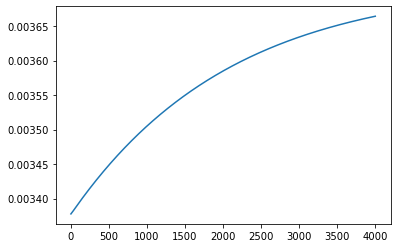

In [23]:
plt.plot(frE1_b60[9,:])

In [27]:
frE1_b60.max()

0.05514893930413081

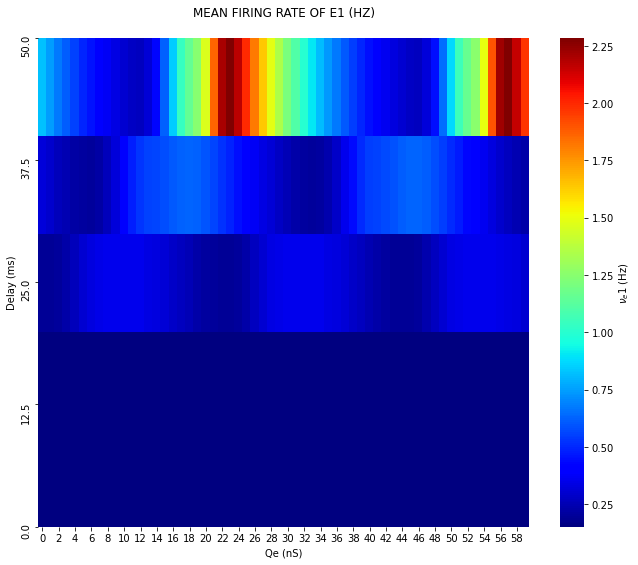

In [14]:
import seaborn as sns
#sns.heatmap(firing_rate,cmap='jet')
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
ax=sns.heatmap(frE1_b60[:,3140:3200]*(2.5/6e-2), cmap="jet",cbar_kws={'label': '$\\nu_e1$ (Hz)', 'orientation': 'vertical'})
plt.xlabel('Qe (nS)')
plt.ylabel('Delay (ms)')
#ax.set_xticks(np.linspace(0,50,10))
#ax.set_xticklabels(np.linspace(0,50,10))
ax.set_yticks(np.linspace(0,50,5))
ax.set_yticklabels(np.linspace(0,50,5))
ax.invert_yaxis()
# title
title = 'Mean Firing Rate of E1 (Hz)\n'.upper()
plt.title(title, loc='center')
plt.show()
#[:,900:1100]

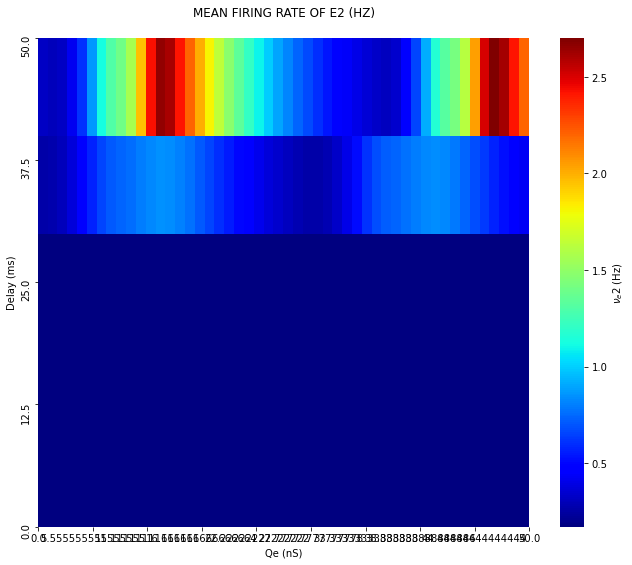

In [18]:
import seaborn as sns
#sns.heatmap(firing_rate,cmap='jet')
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
ax=sns.heatmap(frE2_b60[:,1049:1099]*(3/6e-2), cmap="jet",cbar_kws={'label': '$\\nu_e2$ (Hz)', 'orientation': 'vertical'})
plt.xlabel('Qe (nS)')
plt.ylabel('Delay (ms)')
ax.set_xticks(np.linspace(0,50,10))
ax.set_xticklabels(np.linspace(0,50,10))
ax.set_yticks(np.linspace(0,50,5))
ax.set_yticklabels(np.linspace(0,50,5))
ax.invert_yaxis()
# title
title = 'Mean Firing Rate of E2 (Hz)\n'.upper()
plt.title(title, loc='center')
plt.show()

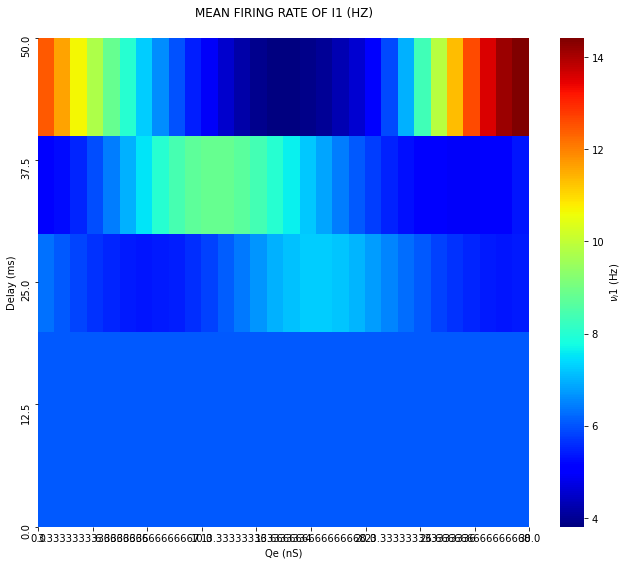

In [71]:
import seaborn as sns
#sns.heatmap(firing_rate,cmap='jet')
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
ax=sns.heatmap(frI1_b60[:,3942:3972]*(14/12), cmap="jet",cbar_kws={'label': '$\\nu_i1$ (Hz)', 'orientation': 'vertical'})
plt.xlabel('Qe (nS)')
plt.ylabel('Delay (ms)')
ax.set_xticks(np.linspace(0,30,10))
ax.set_xticklabels(np.linspace(0,30,10))
ax.set_yticks(np.linspace(0,50,5))
ax.set_yticklabels(np.linspace(0,50,5))
ax.invert_yaxis()
# title
title = 'Mean Firing Rate of I1 (Hz)\n'.upper()
plt.title(title, loc='center')
plt.show()

In [51]:
frI2_b60.max()

12.386281650111133

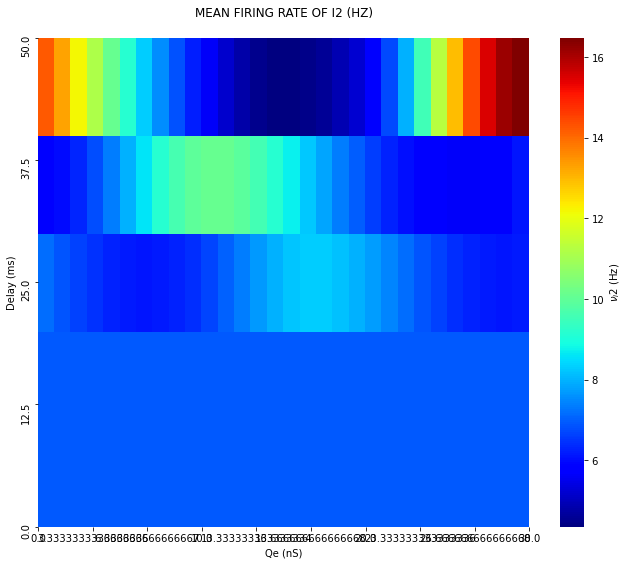

In [72]:
import seaborn as sns
#sns.heatmap(firing_rate,cmap='jet')
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
ax=sns.heatmap(frI2_b60[:,3942:3972]*(16/12), cmap="jet",cbar_kws={'label': '$\\nu_i2$ (Hz)', 'orientation': 'vertical'})
plt.xlabel('Qe (nS)')
plt.ylabel('Delay (ms)')
ax.set_xticks(np.linspace(0,30,10))
ax.set_xticklabels(np.linspace(0,30,10))
ax.set_yticks(np.linspace(0,50,5))
ax.set_yticklabels(np.linspace(0,50,5))
ax.invert_yaxis()
# title
title = 'Mean Firing Rate of I2 (Hz)\n'.upper()
plt.title(title, loc='center')
plt.show()

# Perturbation

In [26]:
AmpStim1=0.5
#Binp=2
def heaviside(x):
    return 0.5 * (1 + np.sign(x))


def input_rate(t, t1_exc, tau1_exc, tau2_exc, ampl_exc):
    # t1_exc=10. # time of the maximum of external stimulation
    # tau1_exc=20. # first time constant of perturbation = rising time
    # tau2_exc=50. # decaying time
    # ampl_exc=20. # amplitude of excitation
    inp = ampl_exc * (np.exp(-(t - t1_exc) ** 2 / (2. * tau1_exc ** 2)) * heaviside(-(t - t1_exc)) + \
                      np.exp(-(t - t1_exc) ** 2 / (2. * tau2_exc ** 2)) * heaviside(t - t1_exc))
    return inp

'''
input_rate=params['inp_funct']

if (input_rate != 0): input_func=input_rate(t, *params['inp_par'])
else : input_func=0

ji, 1000., 10., 400., AmpStim1))
'''

params['inp_funct']=input_rate # input function
params['inp_par']=[1., 0.02, 0.02, AmpStim1] # input parameters

In [28]:
np.random.seed(10)
x0=final_state.copy()
#x0[0]+=0.5
print(x0)
time=0
t_trace=[]
x_trace_RS=[]
TF_trace_RS=[]

x_trace_RS.append(x0.copy())
#x_trace_RS.append(x0.copy())

##################### INITIATE THE PAST COORDINANTES ##########################

delay_matrix=np.matrix(delays)
max_delay=delay_matrix.max()
print('Max delay = ', max_delay)
#### Associated number of time steps ####

steps=int(max_delay/params['tstep'])

for i in range(steps):x_trace_RS.append(x0.copy())
    
##################################################################################

print(x0)
time=0
    
for i in np.arange(0,2,params['tstep']):
    params['x_hist']=np.transpose(x_trace_RS)
    TF_inst=Euler_method_General(x0,params,time,MeanField_dN_dp_delay)
    if (i%0.5==0):print('i = ', i, '\n')
    time+=params['tstep']
    t_trace.append(time)
    x_trace_RS.append(x0.copy())
    TF_trace_RS.append(TF_inst.copy())

[1.98060436e+02 1.98060436e+02 1.98060436e+02 1.98060436e+02
 2.41120340e-02 1.02540284e-04 1.08159073e-04 5.16086214e-05
 1.02540284e-04 2.41120340e-02 5.16086214e-05 1.08159073e-04
 1.08159073e-04 5.16086214e-05 9.61514202e-02 6.76956189e-07
 5.16086214e-05 1.08159073e-04 6.76956189e-07 9.61514202e-02
 1.70716533e-10 1.70716533e-10]
Max delay =  0.001
[1.98060436e+02 1.98060436e+02 1.98060436e+02 1.98060436e+02
 2.41120340e-02 1.02540284e-04 1.08159073e-04 5.16086214e-05
 1.02540284e-04 2.41120340e-02 5.16086214e-05 1.08159073e-04
 1.08159073e-04 5.16086214e-05 9.61514202e-02 6.76956189e-07
 5.16086214e-05 1.08159073e-04 6.76956189e-07 9.61514202e-02
 1.70716533e-10 1.70716533e-10]
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 



In [29]:
final_state=x_trace_RS[-1]
print(final_state)

[1.98060436e+02 1.98060436e+02 1.98060436e+02 1.98060436e+02
 2.41120339e-02 1.02540280e-04 1.08159066e-04 5.16086162e-05
 1.02540280e-04 2.41120339e-02 5.16086162e-05 1.08159066e-04
 1.08159066e-04 5.16086162e-05 9.61514201e-02 6.76956109e-07
 5.16086162e-05 1.08159066e-04 6.76956109e-07 9.61514201e-02
 1.94361770e-10 1.94361770e-10]


In [30]:
x_transp=np.transpose(x_trace_RS)
TF_transp=np.transpose(TF_trace_RS)
ve1=x_transp[0]#[1000:] # remove first 10000 elements
ve2=x_transp[1]#[1000:]
vi1=x_transp[2]#[1000:]
vi2=x_transp[3]#[1000:]
#ce1i1=np.sqrt(x_transp[5])#[1000:]
#cii=np.sqrt(x_transp[5])#[1000:]
w1=x_transp[20]
w2=x_transp[21]

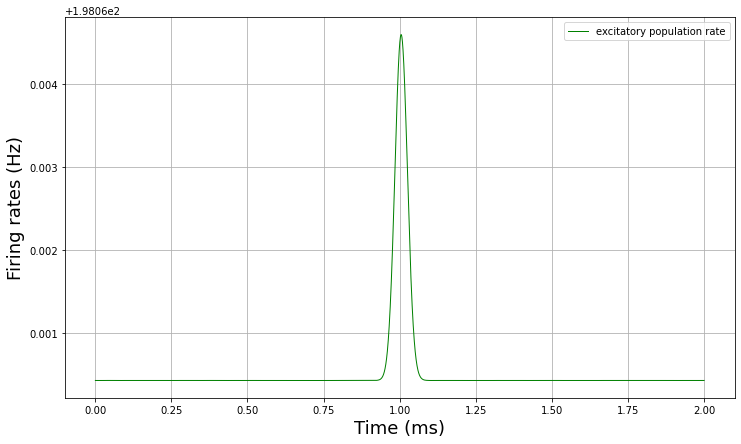

In [36]:
fig,ax=plt.subplots(figsize=(12, 7))

ax.plot(t_trace,ve1[steps+1:],color="green",lw="1",label="excitatory population rate")
#ax.plot(t_trace,vi1[steps+1:],color="red",lw="1",label="inhibitory population rate")
#ax.plot(t[100:]*1000, state_2[100:, 0], color="green",lw="2", ls="--")
#ax.plot(t[100:]*1000, state_2[100:, 1], color="red", lw="2",ls="--")

#ax.plot(t, state_2[:, 2], color="blue", label="excitory cee")
#ax.plot(t, state_2[:, 3], color="purple", label="inhibitory cii")
#ax.plot(t, state_2[:, 4], color="yellow", label="cei")
#ax.plot(t, state_2[:, 5], color="orange", label="cei")
#ax.plot(t,test_input, color="black", linestyle=":", label="forcing")



ax.set_xlabel("Time (ms)",fontsize=18)
ax.grid(True)
ax.set_ylabel("Firing rates (Hz)",fontsize=18)
ax.legend()
#ax.title("Mean-Field Dynamics")
#ax.set_xlim(2,3)
#ax.show()

In [5]:
frE1_euler=np.load('frE1_euler.npy')

In [9]:
frE1[:,0:31]

array([[1.93551043e-02, 2.39881610e-02, 3.00874922e-02, ...,
        1.53462005e-02, 1.41350213e-02, 1.30495211e-02],
       [1.93551043e-02, 2.39881610e-02, 3.00874922e-02, ...,
        1.53462005e-02, 1.41350213e-02, 1.30495211e-02],
       [1.93551043e-02, 2.39881610e-02, 3.00874922e-02, ...,
        1.53462005e-02, 1.41350213e-02, 1.30495211e-02],
       ...,
       [1.93551043e-02, 2.56744575e-02, 2.87048124e-02, ...,
        2.59619935e+00, 3.01374714e+00, 2.04538325e+01],
       [1.93551043e-02, 2.56744575e-02, 2.87048124e-02, ...,
        2.59619935e+00, 3.01374714e+00, 2.04538325e+01],
       [1.93551043e-02, 2.56744575e-02, 2.87048124e-02, ...,
        2.59619935e+00, 3.01374714e+00, 2.04538325e+01]])

(array([1.86753468e+05, 1.20199133e+05, 1.11100747e+03, 8.11076757e+02,
        5.32402467e+02, 3.35708318e+02, 2.26728607e+02, 1.78149036e+02,
        1.59889469e+02, 1.57369280e+02, 1.70136407e+02, 1.98939050e+02,
        2.35435538e+02, 2.56922092e+02, 2.33383211e+04, 6.74623568e+04,
        1.97019053e+04, 1.24249125e+02, 8.20460580e+01, 4.91195722e+01,
        2.77646005e+01, 1.67446773e+01, 1.23733455e+01, 1.10343032e+01,
        1.09549258e+01, 1.26001425e+01, 1.76709784e+01, 2.73103650e+01,
        4.05155534e+01, 2.71016065e+03, 7.45035660e+03, 2.35045698e+03,
        3.35096607e+01, 2.46707271e+01, 1.68192207e+01, 1.11839897e+01,
        8.17267460e+00, 6.91648228e+00, 6.35454609e+00, 6.04582000e+00,
        6.18992086e+00, 7.06942990e+00, 8.52723250e+00, 9.57581829e+00,
        3.46353627e+02, 7.80379911e+02, 2.12052162e+02, 2.54617318e+00,
        1.54960442e+00, 8.30658728e-01, 5.26936599e-01, 4.79008431e-01,
        4.94037347e-01, 4.96205122e-01, 5.05657256e-01, 5.509415

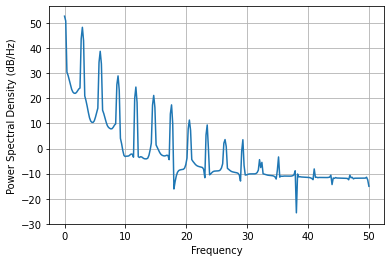

In [31]:
plt.psd(frE1_euler[49,3599:3999]*1e3, 512, 1 / 0.01) #3eme valeur

(array([2.32936664e-02, 4.59442848e-02, 4.40686698e-02, 4.11143443e-02,
        3.73163618e-02, 3.29624290e-02, 2.83593213e-02, 2.37992433e-02,
        1.95308642e-02, 1.57387230e-02, 1.25331081e-02, 9.95068724e-03,
        7.96444819e-03, 6.50020475e-03, 5.45622669e-03, 4.72253473e-03,
        4.19698737e-03, 3.79629708e-03, 3.46130438e-03, 3.15695909e-03,
        2.86830484e-03, 2.59421224e-03, 2.34063573e-03, 2.11484330e-03,
        1.92151903e-03, 1.76101994e-03, 1.62952843e-03, 1.52047991e-03,
        1.42650839e-03, 1.34122473e-03, 1.26036304e-03, 1.18211491e-03,
        1.10673689e-03, 1.03569855e-03, 9.70709348e-04, 9.12924741e-04,
        8.62519095e-04, 8.18669720e-04, 7.79869150e-04, 7.44403636e-04,
        7.10818575e-04, 6.78229712e-04, 6.46411611e-04, 6.15674755e-04,
        5.86605107e-04, 5.59769470e-04, 5.35483192e-04, 5.13701727e-04,
        4.94049289e-04, 4.75953137e-04, 4.58823999e-04, 4.42217815e-04,
        4.25929660e-04, 4.09999465e-04, 3.94640141e-04, 3.801219

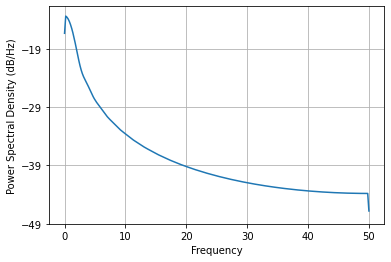

In [86]:
plt.psd(frI1_euler, 512, 1 / 0.01)

In [32]:
frE1_euler[29,1199:3999].shape

(2800,)

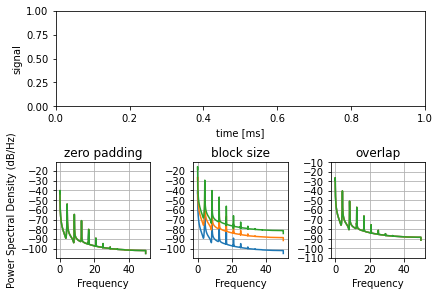

In [36]:
import matplotlib.gridspec as gridspec
dt=0.01
fs = 1. / dt
t=np.linspace(0,10,20000)
# Plot the raw time series
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(2, 3, figure=fig)
ax = fig.add_subplot(gs[0, :])
#ax.plot(t, frE1_euler[29,1199:3999])
ax.set_xlabel('time [ms]')
ax.set_ylabel('signal')


# Plot the PSD with different amounts of zero padding. This uses the entire
# time series at once
ax2 = fig.add_subplot(gs[1, 0])
ax2.psd(frE1_euler[29,1199:3999], NFFT=len(t), pad_to=len(t), Fs=fs)
ax2.psd(frE1_euler[29,1199:3999], NFFT=len(t), pad_to=len(t) * 2, Fs=fs)
ax2.psd(frE1_euler[29,1199:3999], NFFT=len(t), pad_to=len(t) * 4, Fs=fs)
ax2.set_title('zero padding')

# Plot the PSD with different block sizes, Zero pad to the length of the
# original data sequence.
ax3 = fig.add_subplot(gs[1, 1], sharex=ax2, sharey=ax2)
ax3.psd(frE1_euler[29,1199:3999], NFFT=len(t), pad_to=len(t), Fs=fs)
ax3.psd(frE1_euler[29,1199:3999], NFFT=len(t) // 2, pad_to=len(t), Fs=fs)
ax3.psd(frE1_euler[29,1199:3999], NFFT=len(t) // 4, pad_to=len(t), Fs=fs)
ax3.set_ylabel('')
ax3.set_title('block size')

# Plot the PSD with different amounts of overlap between blocks
ax4 = fig.add_subplot(gs[1, 2], sharex=ax2, sharey=ax2)
ax4.psd(frE1_euler[29,1199:3999], NFFT=len(t) // 2, pad_to=len(t), noverlap=0, Fs=fs)
ax4.psd(frE1_euler[29,1199:3999], NFFT=len(t) // 2, pad_to=len(t),
        noverlap=int(0.05 * len(t) / 2.), Fs=fs)
ax4.psd(frE1_euler[29,1199:3999], NFFT=len(t) // 2, pad_to=len(t),
        noverlap=int(0.2 * len(t) / 2.), Fs=fs)
ax4.set_ylabel('')
ax4.set_title('overlap')
plt.show()

In [41]:
t_trace=np.load('t_trace_rk4.npy')

In [38]:
x_trace=np.load('x_trace_rk4.npy')

In [39]:
x_transp=np.transpose(x_trace)
ve1=x_transp[0]#[1000:] # remove first 10000 elements
ve2=x_transp[1]
vi1=x_transp[2]
vi2=x_transp[3]#[1000:]
w1=x_transp[20]
w2=x_transp[21]

/home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


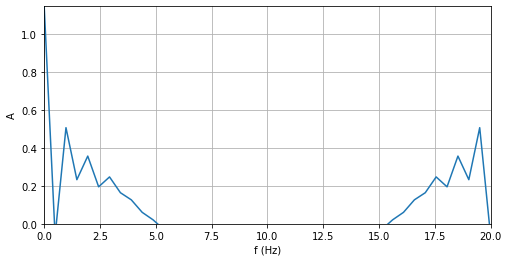

In [46]:
t=t_trace[0:42]*1e2
N = t.size
T = t[N-1]-t[0]
te = t[1]-t[0]
fe = 1.0/te
tfd=np.fft.fft(ve2[0:42]*10)*2/N
a =np.absolute(tfd)
f=np.arange(N)*1.0/T
plt.figure(figsize=(8,4))
plt.plot(f,tfd)
plt.xlabel("f (Hz)")
plt.ylabel("A")
plt.axis([0,fe,0,a.max()])
plt.grid()

In [107]:
frI2[:,0:33]

array([[7.30197061e+00, 1.10357747e+01, 1.30397060e+01, ...,
        5.23284543e+00, 5.20559094e+00, 5.19468059e+00],
       [7.30197061e+00, 1.10357747e+01, 1.30397060e+01, ...,
        5.23284543e+00, 5.20559094e+00, 5.19468059e+00],
       [7.30197061e+00, 1.10357747e+01, 1.30397060e+01, ...,
        5.23284543e+00, 5.20559094e+00, 5.19468059e+00],
       ...,
       [7.30197061e+00, 1.10433817e+01, 1.38558479e+01, ...,
        3.51243128e+00, 5.66412599e+00, 1.20191972e+13],
       [7.30197061e+00, 1.10433817e+01, 1.38558479e+01, ...,
        3.51243128e+00, 5.66412599e+00, 1.20191972e+13],
       [7.30197061e+00, 1.10433817e+01, 1.38558479e+01, ...,
        3.51243128e+00, 5.66412599e+00, 1.20191972e+13]])

In [37]:
frI2=np.load('frI2.npy')

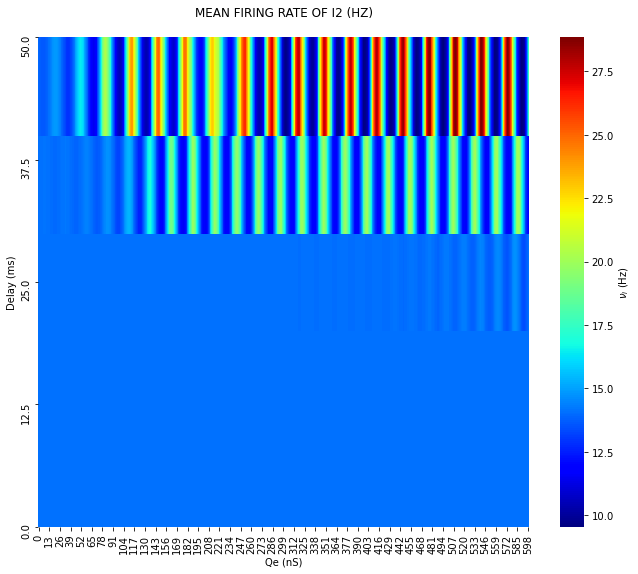

In [153]:
import seaborn as sns
#sns.heatmap(firing_rate,cmap='jet')
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
ax=sns.heatmap(frI2_euler[:,400:1000], cmap="jet",cbar_kws={'label': '$\\nu_i$ (Hz)', 'orientation': 'vertical'})
plt.xlabel('Qe (nS)')
plt.ylabel('Delay (ms)')
#ax.set_xticks(np.linspace(0,32,10))
#ax.set_xticklabels(np.linspace(0,32,10))
ax.set_yticks(np.linspace(0,50,5))
ax.set_yticklabels(np.linspace(0,50,5))
ax.invert_yaxis()
# title
title = 'Mean Firing Rate of I2 (Hz)\n'.upper()
plt.title(title, loc='center')
plt.show()

In [135]:
abs(frI1[:,24])

array([ 5.29224668,  5.29224668,  5.29224668,  5.29224668,  5.29224668,
        5.29224668,  5.29224668,  5.29224668,  5.29224668,  5.29224668,
        6.4158507 ,  6.4158507 ,  6.4158507 ,  6.4158507 ,  6.4158507 ,
        6.4158507 ,  6.4158507 ,  6.4158507 ,  6.4158507 ,  6.4158507 ,
       21.41681968, 21.41681968, 21.41681968, 21.41681968, 21.41681968,
       21.41681968, 21.41681968, 21.41681968, 21.41681968, 21.41681968,
       19.61599654, 19.61599654, 19.61599654, 19.61599654, 19.61599654,
       19.61599654, 19.61599654, 19.61599654, 19.61599654, 19.61599654,
       16.98468031, 16.98468031, 16.98468031, 16.98468031, 16.98468031,
       16.98468031, 16.98468031, 16.98468031, 16.98468031, 16.98468031])

In [129]:
np.arange(1.5e-9,2.2e-9,7e-11)

array([1.50e-09, 1.57e-09, 1.64e-09, 1.71e-09, 1.78e-09, 1.85e-09,
       1.92e-09, 1.99e-09, 2.06e-09, 2.13e-09])

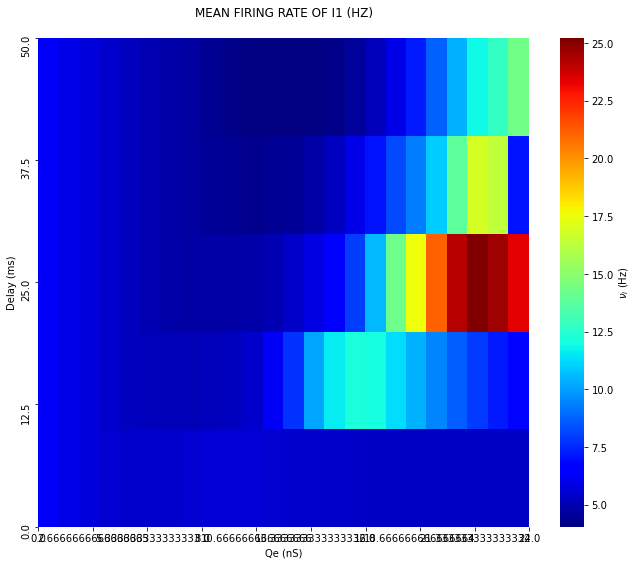

In [141]:
import seaborn as sns
#sns.heatmap(firing_rate,cmap='jet')
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
ax=sns.heatmap(frI2[:,0:24], cmap="jet",cbar_kws={'label': '$\\nu_i$ (Hz)', 'orientation': 'vertical'})
plt.xlabel('Qe (nS)')
plt.ylabel('Delay (ms)')
ax.set_xticks(np.linspace(0,24,10))
ax.set_xticklabels(np.linspace(0,24,10))
ax.set_yticks(np.linspace(0,50,5))
ax.set_yticklabels(np.linspace(0,50,5))
ax.invert_yaxis()
# title
title = 'Mean Firing Rate of I1 (Hz)\n'.upper()
plt.title(title, loc='center')
plt.show()

### Load network activity to compare with MF

In [77]:
popRateG1=data[0]
popRateG2=data[1]
LwG2=data[2]
LVG1=data[3]
LVG2=data[4]
LfrG1=data[5]
LfrG2=data[6]
TimBinned=data[7]
time_array=data[8]

In [ ]:
trains = M1G1.spike_trains()
isi_mu = full(num_tau, nan)*second
isi_std = full(num_tau, nan)*second
for idx in range(num_tau):
    train = diff(trains[idx])
    if len(train)>1:
        isi_mu[idx] = mean(train)
        isi_std[idx] = std(train)
errorbar(tau_range/ms, isi_mu/ms, yerr=isi_std/ms)
xlabel(r'$\tau$ (ms)')
ylabel('Interspike interval (ms)');

In [8]:
M1G2_list=list(M1G2.i)
M1G4_list=list(M1G4.i)

In [19]:
exc_sp=(M1G2.i)+(M1G4.i[0:60328])
exec_time=(M1G2.t/ms)+(M1G4.t/ms)[0:60328]

No handles with labels found to put in legend.


[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

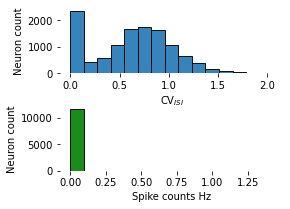

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(4, 3))
sp = exc_sp
times = exec_time
nNeurons = max(sp) + 1
nSpikes = len(sp)

spiketimes = {}
for n in range(nNeurons):
    ts = list(times[(np.where(sp == n))])
    #ts = [t for t in ts if t > 500 * ms]
    spiketimes[n] = ts
isi_stds = []
isi_cvs = []
for n in range(nNeurons):
    isi_std = np.std(np.diff(spiketimes[n]))
    isi_cv = np.std(np.diff(spiketimes[n])) / np.mean(np.diff(spiketimes[n]))
        #plt.scatter(n, np.std(np.diff(spiketimes[n])))
    isi_stds.append(isi_std)  
    isi_cvs.append(isi_cv)
        
meanFiringRates = []
for n in range(nNeurons):
    meanFiringRates.append(1/np.mean(np.diff(spiketimes[n])))
        
    

axs[0].hist(isi_cvs, bins=15, alpha=0.9, edgecolor='black');#bins=15, alpha=0.9, edgecolor='black'
axs[1].hist(meanFiringRates,bins=15, alpha=0.9, edgecolor='black',color="green");
    
for k in range(1):
    leg = axs[k].legend(loc=1)
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
   
for k in range(2):
    axs[k].spines['right'].set_visible(False)
    axs[k].spines['top'].set_visible(False)
    axs[k].spines['bottom'].set_visible(False)
    axs[k].spines['left'].set_visible(False)
#axs[0].set_xticks([0, 0.5, 1.0])
#axs[0].set_yticks([0, 10, 20])

#axs[0].set_xlim(0, 1.6)
axs[0].set_xlabel("CV$_{ISI}$")
axs[1].set_xlabel("Spike counts Hz")

axs[0].set_ylabel("Neuron count")
axs[1].set_ylabel("Neuron count")

plt.subplots_adjust(hspace=0.5)
print(meanFiringRates)

WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 [py.warnings]
WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
 [py.warnings]
WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]
WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 [py.warnings]
WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]
No h

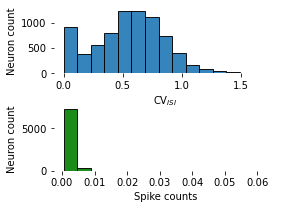

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(4, 3))
sp = M1G4.i
times = M1G4.t/ms
nNeurons = max(sp) + 1
nSpikes = len(sp)

spiketimes = {}
for n in range(nNeurons):
    ts = list(times[(np.where(sp == n))])
    #ts = [t for t in ts if t > 500 * ms]
    spiketimes[n] = ts
isi_stds = []
isi_cvs = []
for n in range(nNeurons):
    isi_std = np.std(np.diff(spiketimes[n]))
    isi_cv = np.std(np.diff(spiketimes[n])) / np.mean(np.diff(spiketimes[n]))
        #plt.scatter(n, np.std(np.diff(spiketimes[n])))
    isi_stds.append(isi_std)  
    isi_cvs.append(isi_cv)
        
meanFiringRates = []
for n in range(nNeurons):
    meanFiringRates.append(1/np.mean(np.diff(spiketimes[n])))
        
    

axs[0].hist(isi_cvs, bins=15, alpha=0.9, edgecolor='black');
axs[1].hist(meanFiringRates,bins=15, alpha=0.9, edgecolor='black',color="green");
    
for k in range(1):
    leg = axs[k].legend(loc=1)
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
   
for k in range(2):
    axs[k].spines['right'].set_visible(False)
    axs[k].spines['top'].set_visible(False)
    axs[k].spines['bottom'].set_visible(False)
    axs[k].spines['left'].set_visible(False)
#axs[0].set_xticks([0, 0.5, 1.0])
#axs[0].set_yticks([0, 10, 20])

#axs[0].set_xlim(0, 1.6)
axs[0].set_xlabel("CV$_{ISI}$")
axs[1].set_xlabel("Spike counts")

axs[0].set_ylabel("Neuron count")
axs[1].set_ylabel("Neuron count")

plt.subplots_adjust(hspace=0.5)

### Draw distribution

1.0000000000000007e-08 1.1180339887219443e-05 0.5247965918467479 6.491887650492998e-06 0.6390968632923207 0.1490945045420307 4.613344479985466 0.40508183579432433


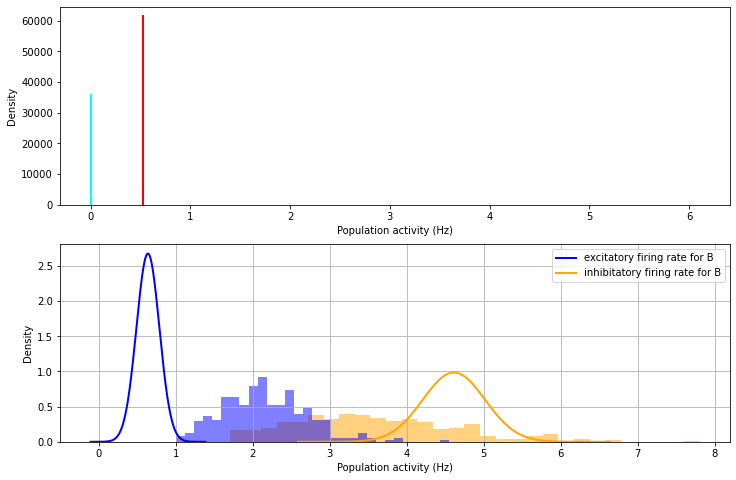

In [20]:
import scipy.stats
import cmath

def gaussian(x,mean,std):
    return 1/(np.sqrt(2*math.pi*std**2))*math.exp(-(x-mean)**2/(2*std**2))

fig, axs = plt.subplots(2, 1, figsize=(12, 8))

'''Remove transient'''

ST_popRateG1=popRateG1[int(len(popRateG1)/5)::] 
ST_popRateG2=popRateG2[int(len(popRateG2)/5)::]
ST_popRateG3=popRateG3[int(len(popRateG3)/5)::] 
ST_popRateG4=popRateG4[int(len(popRateG4)/5)::]

axs[0].hist(ST_popRateG1, color='red',density= True, bins=30, alpha=0.5)
axs[0].hist(ST_popRateG2, color='cyan',density=True, bins=30, alpha=0.5)
axs[1].hist(ST_popRateG3, color='orange',density= True, bins=30, alpha=0.5)
axs[1].hist(ST_popRateG4, color='blue',density=True, bins=30, alpha=0.5)


mean_RS1=final_state[0]
std_RS1=np.sqrt(final_state[4])

mean_RS2=final_state[1]
std_RS2=np.sqrt(final_state[9])

mean_FS1=final_state[2]
std_FS1=np.sqrt(final_state[12])

mean_FS2=final_state[3]
std_FS2=np.sqrt(final_state[19])


print(mean_RS1,std_RS1,mean_FS1,std_FS1,mean_RS2,std_RS2,mean_FS2,std_FS2)

x_min_RS1=mean_RS1-5*std_RS1 #x_min_RS=mean_RS-5*std_RS
x_max_RS1=mean_RS1+5*std_RS1

x_min_RS2=mean_RS2-5*std_RS2 #x_min_RS=mean_RS-5*std_RS
x_max_RS2=mean_RS2+5*std_RS2

x_min_FS1=mean_FS1-5*std_FS1
x_max_FS1=mean_FS1+5*std_FS1

x_min_FS2=mean_FS2-5*std_FS2
x_max_FS2=mean_FS2+5*std_FS2

x_RS1 = np.linspace(x_min_RS1, x_max_RS1, 1000)
x_FS1 = np.linspace(x_min_FS1, x_max_FS1, 1000)
x_RS2 = np.linspace(x_min_RS2, x_max_RS2, 1000)
x_FS2 = np.linspace(x_min_FS2, x_max_FS2, 1000)


Distrib_RS1=[]
Distrib_FS1=[]
Distrib_RS2=[]
Distrib_FS2=[]


for i in range(len(x_RS1)):
    Distrib_RS1.append(gaussian(x_RS1[i],mean_RS1,std_RS1))
    Distrib_RS2.append(gaussian(x_RS2[i],mean_RS2,std_RS2))
    Distrib_FS1.append(gaussian(x_FS1[i],mean_FS1,std_FS1))
    Distrib_FS2.append(gaussian(x_FS2[i],mean_FS2,std_FS2))


axs[0].plot(x_RS1,Distrib_RS1,color='cyan',lw=2,label='excitatory firing rate for A')
axs[1].plot(x_RS2,Distrib_RS2,color='blue',lw=2,label='excitatory firing rate for B')
axs[0].plot(x_FS1,Distrib_FS1,color='red',lw=2, label='inhibitatory firing rate for A')
axs[1].plot(x_FS2,Distrib_FS2,color='orange',lw=2, label='inhibitatory firing rate for B')
                             
axs[0].set_xlabel("Population activity (Hz)")
axs[0].set_ylabel("Density")
axs[1].set_xlabel("Population activity (Hz)")
axs[1].set_ylabel("Density")
plt.grid(True)
#plt.ylabel("Density")
plt.legend()
plt.show()